In [1]:
%matplotlib inline

import pandas as pd
# pd.core.common.is_list_like = pd.api.types.is_list_like
from matplotlib import style
# from pandas_datareader import data
import random
# from SALib.sample import latin
from functions.stylizedfacts import *
import scipy.stats as stats
# from functions.evolutionaryalgo import *
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns
import json
import math
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

# Estimate model
Following the procedure presented by [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802).

The model should produce realistic booms-bust / deviations from the fundamentals as well as some standard no-autocorrelation moments associated with financial markets. 

Returns:
1. Average autocorrelation
2. Average absolute autocorrelation
3. Kurtosis

Bubbles:
4. percentage bubble occurence of total periods
5. average lenght of bubbles
6. standard deviation lenght of bubbles
7. skewness lenght of bubbles
8. kurtosis lenght of bubbles 


## 1 Get data

In [3]:
# start_date = '2008-12-31' #1933
# end_date = '2018-12-31'

# spy_nom_price = data.DataReader("SP500", 
#                        start=start_date, 
#                        end=end_date, 
#                        data_source='fred')["SP500"].dropna()
# spy_nom_returns = spy_nom_price.pct_change()[1:]

In [4]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]

### 1.a Bubbles in the data

In [70]:
p = pd.Series(np.array(shiller_data.iloc[1175:]['Price'])) #starting in 1952  was 1224
y = pd.Series(np.array(shiller_data.iloc[1175:]['CAPE']))  

In [78]:
len(y)

600

In [72]:
obs = len(y)
r0 = 0.01 + 1.8/np.sqrt(obs)
swindow0 = int(math.floor(r0*obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 99

In [73]:
bsadfs = PSY(y, swindow0, IC, adflag)
quantilesBsadf = cvPSYwmboot(y, swindow0, IC, adflag, Tb, nboot=199)

In [74]:
monitorDates = y.iloc[swindow0-1:obs].index
quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
ind95 =(bsadfs.T[0] > quantile95[1, ])
periods = monitorDates[ind95]

Rewrite find sequence in ints 

In [75]:
bubbly_dates = find_sequences_ints(periods, monitorDates)

Text(0,0.5,'Ratio')

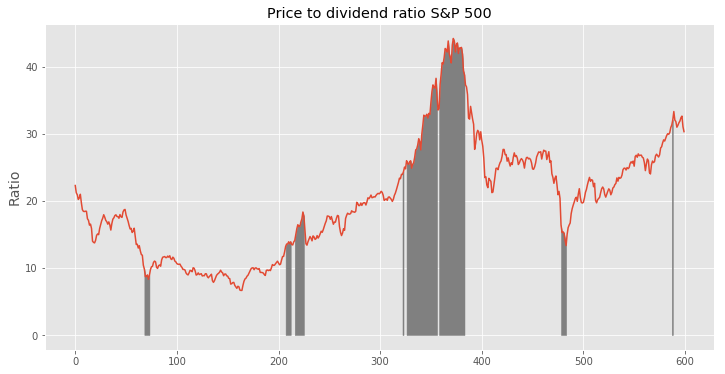

In [77]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,6))

ax1.plot(range(len(y)), y)

for loc in range(len(bubbly_dates)):
    bub_period = bubble_period(monitorDates , bubbly_dates.iloc[loc])
    ax1.fill_between(bub_period , y[bub_period], color='grey')
    
ax1.set_title('Price to dividend ratio S&P 500')
ax1.set_ylabel('Ratio', fontsize='14')

#fig.savefig('sp500_bubbel.png')

#### Bubble moments

1. Percentage bubble occurence of total periods

In [79]:
# percentage bubble occurence 
percentage_bubbles = len(periods) / float(len(monitorDates))
percentage_bubbles

0.15789473684210525

2. Average lenght of bubbles

In [80]:
# av bubble lenght
lenghts_of_bubbles = []
for row in range(len(bubbly_dates)):
    lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)

In [81]:
av_lenght_bubbles = np.mean(lenghts_of_bubbles)
av_lenght_bubbles

10.875

3. Standard deviation lenght of bubbles

In [82]:
stdev_lenght_bubbles = np.std(lenghts_of_bubbles)
stdev_lenght_bubbles

10.611756452161913

4. Skew lenght of bubbles

In [83]:
pd.Series(lenghts_of_bubbles).skew()

1.2181227241543175

5. Kurtosis lenght of bubbles

In [84]:
pd.Series(lenghts_of_bubbles).kurtosis()

0.0077702233939218601

## 2 Bootstrap data for both short and long-term moments

In [85]:
shiller_block_size = 120 # 5 blocks

To ensure continuity in the bootstrapped series, I block bootstrap the returns of the price to dividends ratio(not the ratio itself). Then, I multiply these returns with the starting values of the price to dividends ratio. This results in 5000 hypothetical time series of fundamentals and real prices. 

In [ ]:
fundamental_returns = pd.Series(y).pct_change()[1:]

In [ ]:
def hypothetical_series(starting_value, returns):
    """
    input: starting_value: float starting value
    input: returns: list 
    """
    returns = list(returns)
    simulated_series = [starting_value]
    for idx in range(len(returns)):
        simulated_series.append(simulated_series[-1] * (1 + returns[idx]))
    return simulated_series

In [ ]:
# divide the returns into blocks
shiller_data_blocks = []
for x in range(0, len(fundamental_returns[:-3]), shiller_block_size):
    shiller_data_blocks.append(fundamental_returns[x:x+shiller_block_size])

In [ ]:
# draw 5000 random series 
bootstrapped_shiller_series = []
for i in range(5000):
    #print(i)
    # first sample the data
    sim_data = [random.choice(shiller_data_blocks) for _ in shiller_data_blocks] # choose a random set of blocks
    sim_data_fundamental_returns = [pair for pair in sim_data]
    #sim_data_price_returns = [pair[1] for pair in sim_data]
    
    # merge the list of lists
    sim_data_fundamental_returns1 = [item for sublist in sim_data_fundamental_returns for item in sublist]
    #sim_data_price_returns1 = [item for sublist in sim_data_price_returns for item in sublist]
    
    # calculate the new time_series
    sim_data_fundamentals = hypothetical_series(fundamental_values[0], sim_data_fundamental_returns1)
    #sim_data_prices = hypothetical_series(real_prices[0], sim_data_price_returns1)
    
    bootstrapped_shiller_series.append((sim_data_fundamentals, sim_data_prices))

In [5]:
small_block_size = 250 # 250
large_block_size = 625 # 750

**Small data blocks returns**
For short term moments, I produce a bootstrapped series of 250 day (= 1 year) data blocks. This means that there are 25 unique blocks. 

In [6]:
small_data_blocks = []
for x in range(0, len(spy_nom_returns), small_block_size):
    small_data_blocks.append(list(spy_nom_returns[x:x+small_block_size]))
    
# draw 5000 random series
bootstrapped_small_series = []
for i in range(5000):
    sim_data = [random.choice(small_data_blocks) for _ in small_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_small_series.append(sim_data2)

**Large data blocks returns**

For the longer moments, I produce a bootstrapped series of data blocks of 625 days. To accomodate this, I cut the data set with 250 observations, to 6000 observations. 

In [7]:
large_data_blocks = []
for x in range(0, len(spy_nom_returns), large_block_size): # used to be len(spy_nom_returns[:-250])
    large_data_blocks.append(list(spy_nom_returns[x:x+large_block_size]))
    
# draw 5000 random series
bootstrapped_long_series = []
for i in range(5000):
    sim_data = [random.choice(large_data_blocks) for _ in large_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_long_series.append(sim_data2)

## 3 Choose moments

For returns, I use the following moments **short-term moments**: 

1. mean first-order autocorrelation of the raw returns (no predictability),
2. autocorrelations at lags t ¼ 1
3. autocorrelations at lags t ¼ 5
4. mean first-order autocorrelation of the of the absolute returns (volatility clustering),
5. Kurtosis (fat tails), 

In [8]:
first_order_autocors = []
mean_abs_autocor = []
autocors1 = []
autocors5 = []
kurtoses = []
for rets in bootstrapped_small_series:
    first_order_autocors.append(autocorrelation_returns(rets, 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(rets, 25))
    rets = pd.Series(rets)
    autocors1.append(rets.autocorr(lag=1))
    autocors5.append(rets.autocorr(lag=5))
    kurtoses.append(kurtosis(rets))

For long-term moments, I use the autocorrelation of returns for the with lags (10, 25, 50, 100, 150 and 200).

In [9]:
spy_abs_auto10 = []
spy_abs_auto25 = []
spy_abs_auto50 = []
spy_abs_auto100 = []
spy_abs_auto150 = []
spy_abs_auto200 = []

for rets in bootstrapped_long_series:
    rets = pd.Series(rets)
    spy_abs_auto10.append(rets.abs().autocorr(lag=10))
    spy_abs_auto25.append(rets.abs().autocorr(lag=25))
    spy_abs_auto50.append(rets.abs().autocorr(lag=50))
    spy_abs_auto100.append(rets.abs().autocorr(lag=100))
    spy_abs_auto150.append(rets.abs().autocorr(lag=150))
    spy_abs_auto200.append(rets.abs().autocorr(lag=200))

In [10]:
all_bootstrapped_moments = [first_order_autocors,
                            autocors1,
                            autocors5,
                            mean_abs_autocor,
                            kurtoses,
                            spy_abs_auto10,
                            spy_abs_auto25,
                            spy_abs_auto50,
                            spy_abs_auto100,
                            spy_abs_auto150,
                            spy_abs_auto200
                           ]

In [11]:
# Get the t-critical value**
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

In [13]:
def get_specific_bootstraps_moments(full_series, bootstrap_number):
    """Get a vector with the moments of a specific bootstrap"""
    return np.array([full_series[i][bootstrap_number] for i in range(len(full_series))])

In [14]:
av_moments = [np.mean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_long_series))]

In [15]:
av_moments

[-0.009590142288147235,
 -0.053186232819994565,
 -0.06599977989787965,
 0.19067785131262055,
 4.664644807691542,
 0.22032722499815627,
 0.12291300355839241,
 0.06404942852887105,
 0.005154107179098744,
 0.02923536866422375,
 0.011158749795494532]

## 5 Estimate weighting matrix:

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [16]:
emp_moments = np.array([
        autocorrelation_returns(spy_nom_returns, 25),
        spy_nom_returns.autocorr(lag=1),
        spy_nom_returns.autocorr(lag=5),
        autocorrelation_abs_returns(spy_nom_returns, 25),
        kurtosis(spy_nom_returns),
        spy_nom_returns.abs().autocorr(lag=10),
        spy_nom_returns.abs().autocorr(lag=25),
        spy_nom_returns.abs().autocorr(lag=50),
        spy_nom_returns.abs().autocorr(lag=100),
        spy_nom_returns.abs().autocorr(lag=150),
        spy_nom_returns.abs().autocorr(lag=200)
    ])

In [17]:
emp_moments

array([-8.74066270e-03, -5.33776990e-02, -6.66910229e-02,  2.10895461e-01,
        4.97365239e+00,  2.30863270e-01,  1.38701437e-01,  7.70690242e-02,
        3.67428481e-02,  4.59816817e-02,  2.60152688e-03])

In [18]:
# prevent NA errors
spy_abs_auto50 = list(pd.Series(spy_abs_auto50).fillna(0))
spy_abs_auto100 = list(pd.Series(spy_abs_auto100).fillna(0))
spy_abs_auto150 = list(pd.Series(spy_abs_auto150).fillna(0))
spy_abs_auto200 = list(pd.Series(spy_abs_auto200).fillna(0))

Then, I estimate the moment covariance matrix of the bootstrapped data as: 

$\hat{W} = \frac{1}{B} \sum{(m^b - \hat{m})(m^b - \hat{m})'}$

In [19]:
W_hat = 1.0 / len(bootstrapped_long_series) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])

And take the inverse so that 

$W = \hat{W}^{-1}$

In [20]:
W = np.linalg.inv(W_hat)

In [21]:
# save weighting matrix
np.save('distr_weighting_matrix', W)

In [22]:
np.load('distr_weighting_matrix.npy')

array([[ 6.81465475e+05, -2.64829749e+04, -9.25200729e+03,
        -1.99887686e+04,  7.94996677e+02, -3.17697747e+02,
         6.04248599e+02, -6.88767257e+01, -5.47611936e+02,
         6.50115515e+02, -2.12910702e+01],
       [-2.64829749e+04,  6.60452261e+03, -1.47353148e+03,
         2.73008315e+03, -5.36742011e+01,  4.90536671e+01,
        -4.53870180e+01, -1.04242066e+01,  3.39610426e+01,
        -3.89302874e+01,  3.93909503e+01],
       [-9.25200729e+03, -1.47353148e+03,  2.04288931e+03,
        -4.91690500e+01, -7.48703816e+00,  3.45701629e+01,
         1.26220576e+01, -1.78545409e+01,  3.44605163e+01,
         3.12484613e+01, -4.30126911e+01],
       [-1.99887686e+04,  2.73008315e+03, -4.91690500e+01,
         3.05977123e+03, -9.08029955e+01,  3.54822578e+01,
        -7.84199612e+01,  5.22858210e+01, -1.85786499e+00,
         1.90173697e+00, -4.06171649e+00],
       [ 7.94996677e+02, -5.36742011e+01, -7.48703816e+00,
        -9.08029955e+01,  4.23992445e+00,  1.36164026e+00,
  

In [25]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]
bigger_confidence_intervals = [bigger_confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [26]:
confidence_intervals

[(-0.01250895315270514, -0.004972372250184702),
 (-0.10254115435603452, -0.004214243562520606),
 (-0.13326354929237721, -0.00011849649034352538),
 (0.1191595975547408, 0.302631324267812),
 (2.854538589493186, 7.092766197859348),
 (0.17148566039471264, 0.29024088013441146),
 (0.068621817622279, 0.2087810573343057),
 (0.011467242780874146, 0.14267080559615264),
 (-0.019033843604341717, 0.0925195398866297),
 (-0.020147409674270055, 0.11211077299605529),
 (-0.04900123713528164, 0.054204290890615035)]

In [22]:
# export conrfidence intervals of bootstrapped data
with open('distr_bootstrapped_confidence_intervals.json', 'w') as fp:
    json.dump(confidence_intervals, fp)

Then, I apply the cost function to the bootstrapped series to get a distribution of J-values

In [23]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

In [24]:
# export J-values of bootstrapped data
with open('distr_bootstrapped_j_values.json', 'w') as fp:
    json.dump(j_values, fp)